In [33]:
!uv pip install jupyterlab-vim jupyterlab-execute-time

Using Python 3.12.3 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv
Resolved 94 packages in 115ms
Installed 2 packages in 28ms
 + jupyterlab-execute-time==3.2.0
 + jupyterlab-vim==4.1.4


In [1]:
from pathlib import Path
import fastplotlib as fpl
import os
import sys
import masknmf
import tifffile
%load_ext autoreload

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


In [2]:
fpath = Path(r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled\plane_07_mk301.tiff")
data = tifffile.memmap(fpath)
data.shape

(64594, 448, 448)

RFBOutputContext()

C:\Users\RBO\repos\masknmf-toolbox\.venv\Lib\site-packages\fastplotlib\graphics\_features\_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='448.0px', css_width='448.0px')
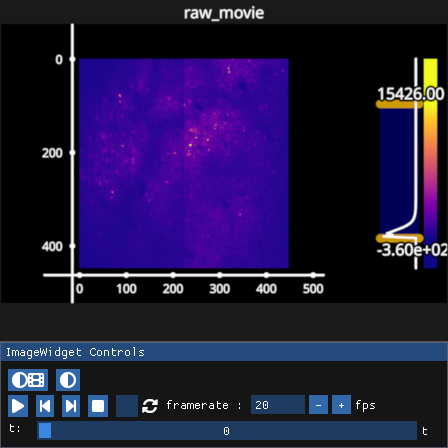

In [3]:
iw = fpl.ImageWidget(data=[data], names=["raw_movie"], figure_kwargs={"size": (data.shape[-1], data.shape[-2])})
iw.show()

# Define a rigid motion correction strategy. Optionally provide a template as a 2D torch.Tensor

In [4]:
max_rigid_shifts = [3, 3]
template = None
rigid_strategy = masknmf.RigidMotionCorrection(max_rigid_shifts, template = template)

# If template is not provided, run the general template update procedure below

In [5]:
rigid_strategy = masknmf.compute_template(data,
                                          rigid_strategy, 
                                          device = "cpu")

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


# Define a motion correction array, which lazily loads motion corrected frames aligned via the registation_strategy

In [9]:
moco_results = masknmf.RegistrationArray(data,
                                         rigid_strategy,
                                         device = "cpu")

In [11]:
moco_results.shape

(64594, 448, 448)

In [18]:
type(moco_results)

masknmf.motion_correction.registration_arrays.RegistrationArray

In [30]:
save_path = Path("../../data").resolve()
save_path.mkdir(exist_ok=True)

In [34]:
import numpy as np
# 4 min with batch of 100, 1 min with batch of 500
def save_lazyarray_to_tiff(lazy_array, save_path, batch_size=500):
    n_frames = lazy_array.shape[0]
    with tifffile.TiffWriter(save_path, bigtiff=True) as tif:
        for start in range(0, n_frames, batch_size):
            end = min(start + batch_size, n_frames)
            batch = lazy_array[start:end]
            tif.write(
                batch.astype(np.float32),
                contiguous=True
            )

In [35]:
save_name = save_path.joinpath("plane_07_reg.tiff")
save_lazyarray_to_tiff(moco_results, save_name)

In [ ]:
frame = moco_results[0:200, ...]
fpl.ImageWidget(data=[frame]).show()

# Visualize the raw vs. registered data via fastplotlib

In [17]:
iw = fpl.ImageWidget(datak = [data[::4], moco_results[::4]])
iw.cmap = "gray"
iw.show()

TypeError: ImageWidget.__init__() got an unexpected keyword argument 'datak'